## Tests to understand why ERA5 performs better than nested WRF simulations

#### Loading Python modules:

In [1]:
import numpy as np
import numpy 
from netCDF4 import Dataset
import csv
import glob 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from scipy.ndimage.filters import gaussian_filter
from wrf import ALL_TIMES
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
cartopy_ylim, latlon_coords)
from wrf import getvar, interplevel, interpz3d
import matplotlib.colors as mcolors
import pygrib
import cfgrib
from datetime import datetime
from datetime import datetime, timedelta
from scipy.interpolate import griddata
import pickle
from scipy.spatial import cKDTree

/etc/ecmwf/ssd/ssd1/tmpdirs/bidc.1007203.20240628_080304.435/ipykernel_4013609/3306146100.py:11: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


#### Defining Plot Check to compare ASCAT and nested WRF domain coverage:

In [58]:
def Plot_Check_ASCATvsWRF(mapa,ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,cyc_num,date_cyclone):
    #
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.ndimage import gaussian_filter
    import matplotlib
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs     = Dataset(ASCAT_path+'/'+file_name_ASCAT)
    lat_obs       = ascat_obs['lat'][:,:].data
    lon_obs       = ascat_obs['lon'][:,:].data
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf      = Dataset(WRF_path+'/'+file_name_WRF)
    lat_wrf       = data_wrf['XLAT'][0,:,:].data
    lon_wrf       = data_wrf['XLONG'][0,:,:].data

    # Loading basemap:
    #m_d02 = Basemap(projection='cyl', resolution='c')
    m_d02 = Basemap(projection='robin', resolution='c', lon_0=0)

    # Increase the resolution of the output
    matplotlib.rcParams['figure.dpi'] = 100

    # Create the figure with a larger size for better visualization
    fig = plt.figure(figsize=(12, 14))
    ax = fig.add_subplot(111)

    # Customize the map details
    parallels = np.arange(-90, 90, 20)
    meridians = np.arange(0, 360, 40)
    m_d02.drawcoastlines(color="black", linewidth=1)
    m_d02.drawstates(linestyle="dotted")
    m_d02.drawcountries(linestyle="dotted")
    m_d02.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m_d02.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)

    # Transform coordinates for plotting
    x_obs, y_obs  = m_d02(lon_obs, lat_obs)
    x_wrf, y_wrf  = m_d02(lon_wrf, lat_wrf)

    # Plotting scatter plots:
    cs1 = m_d02.scatter(x_wrf[::6], y_wrf[::6], color='red', label='WRF Model', s=1)
    cs2 = m_d02.scatter(x_obs[::6], y_obs[::6], color='blue',  label='ASCAT Obs', s=1)

    # Title figure:
    plt.title('Spatial Distribution ASCAT Observations (CYC:'+str(cyc_num)+') \n valid at '+str(date_cyclone.strftime('%d-%b-%Y %H:%M:%S')), fontsize=14)
    plt.legend(loc='lower left')

    # Save the figure
    #fig.savefig('Spatial_Distribution_ASCAT_Observations_(CYC:'+str(cyc_num)+')_'+str(date_cyclone.strftime('%d-%b-%Y %H:%M:%S'))+'.png', dpi=300)
    fig.savefig('Spatial_Distribution_ASCAT_Observations_CYC'+str(cyc_num)+'.png', dpi=300)


#### Here goes CODE to interpolate ASCAT observations to same grid model:

In [84]:
def Computing_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,ERA5_path,file_name_ERA5):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #
    # Loading ERA5 geographical coordinates:
    #
    #Opening ERA5 Grib files:
    ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
    # Obtaining variables of interest from ERA5 files:
    lat_era5 = ds['latitude']
    lon_era5 = ds['longitude']
    u10m_era5 = ds['u10'].values
    v10m_era5 = ds['v10'].values
    # Computing wind speed:
    wspeed_era5 = np.sqrt(u10m_era5**2 + v10m_era5**2)
    # Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
    [lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_wrf  = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
    points_era5 = np.c_[lons_era5.flatten(), lats_era5.flatten()]
    values_era5 = wspeed_era5.flatten()
    values_wrf  = wspeed_wrf.flatten()
    points_mesh = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    # Interpolate wrf onto the observation grid:
    #
    wrf_interp = griddata(points_wrf, values_wrf, points_mesh, method='linear', fill_value=np.nan)
    #
    #
    # Interpolate ERA5 onto the observation grid:
    #
    era5_interp = griddata(points_era5, values_era5, points_mesh, method='linear', fill_value=np.nan)
    #
    # Interpolate u and v components of WRF wind to observation sites:
    #
    u10m_wrf_interp = griddata(points_wrf, u10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_wrf_interp = griddata(points_wrf, v10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of ERA5 wind to observation sites:
    #
    u10m_era5_interp = griddata(points_era5, u10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_era5_interp = griddata(points_era5, v10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(wrf_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    wrf_interp_valid      = wrf_interp[valid_mask]
    era5_interp_valid     = era5_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m            = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m            = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_wspeed10m        = np.sqrt(np.mean((wrf_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_u10m             = np.sqrt(np.mean((u10m_wrf_interp - ascat_u10m) ** 2))
    rmse_v10m             = np.sqrt(np.mean((v10m_wrf_interp - ascat_v10m) ** 2))
    rmse_era5_wspeed10m   = np.sqrt(np.mean((era5_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_era5_u10m        = np.sqrt(np.mean((u10m_era5_interp - ascat_u10m) ** 2))
    rmse_era5_v10m        = np.sqrt(np.mean((v10m_era5_interp - ascat_v10m) ** 2))
    #
    print(f'RMSE wspeed10m between model and observations: {rmse_wspeed10m:.2f} m/s')
    print(f'RMSE ERA5 wspeed10m between model and observations: {rmse_era5_wspeed10m:.2f} m/s')
    print(f'RMSE u10m between model and observations: {rmse_u10m:.2f} m/s')
    print(f'RMSE ERA5 u10m between model and observations: {rmse_era5_u10m:.2f} m/s')
    print(f'RMSE v10m between model and observations: {rmse_v10m:.2f} m/s')
    print(f'RMSE ERA5 v10m between model and observations: {rmse_era5_v10m:.2f} m/s')
    #
    # =========================================================
    # Plotting:
    # =========================================================
    #
    # Create the Basemap instance:
    m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
                llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)
    #
    # Plotting the data:
    #
    fig = plt.figure(figsize=(14, 14))
    #
    # First subplot: Observed wind speed and direction:
    # 
    ax1 = fig.add_subplot(311)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    parallels = np.arange(-90, 90, 10)
    meridians = np.arange(0, 360, 10)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    #
    # Transform coordinates for plotting:
    #
    x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
    #
    # Calculate u and v components for observed wind:
    #
    u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    # Plot wind barbs for observed wind speed and direction:
    #
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
    plt.title('Observed Wind Speed and Direction')
    #
    # Second subplot: Interpolated WRF wind speed and direction:
    #
    ax2 = fig.add_subplot(312)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_wrf_interp[::barb_density], v10m_wrf_interp[::barb_density], length=5, color='red')
    plt.title('Interpolated WRF Wind Speed and Direction')
    plt.tight_layout()
    #plt.show()
    #
    # Third subplot: Interpolated ERA5 wind speed and direction:
    #
    ax2 = fig.add_subplot(313)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_era5_interp[::barb_density], v10m_era5_interp[::barb_density], length=5, color='green')
    plt.title('Interpolated ERA5 Wind Speed and Direction')
    plt.tight_layout()
    #plt.show()
    # Save the figure
    fig.savefig('Interpolated_WRFandERA5_Wind_Speed_and_Direction_'+ file_name_WRF +'.png', dpi=300)
    return rmse_wspeed10m, rmse_u10m, rmse_v10m, rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m

## -------------------------- START CODE -------------------------- ##

#### Enter to the work directory where the figures will be stored:

In [54]:
cd /scratch/bidc/DCC/EUMETSAT_Obs/Tests/

/lus/h2resw01/scratch/bidc/DCC/EUMETSAT_Obs/Tests


#### Loading map:

In [5]:
# Loading map:
mapa_d02 = Basemap(projection='robin', resolution='c', lon_0=0)

#### Check the WORST WRF simulation vs ERA5 using ASCAT observations:

2019-01-07 07:00:00


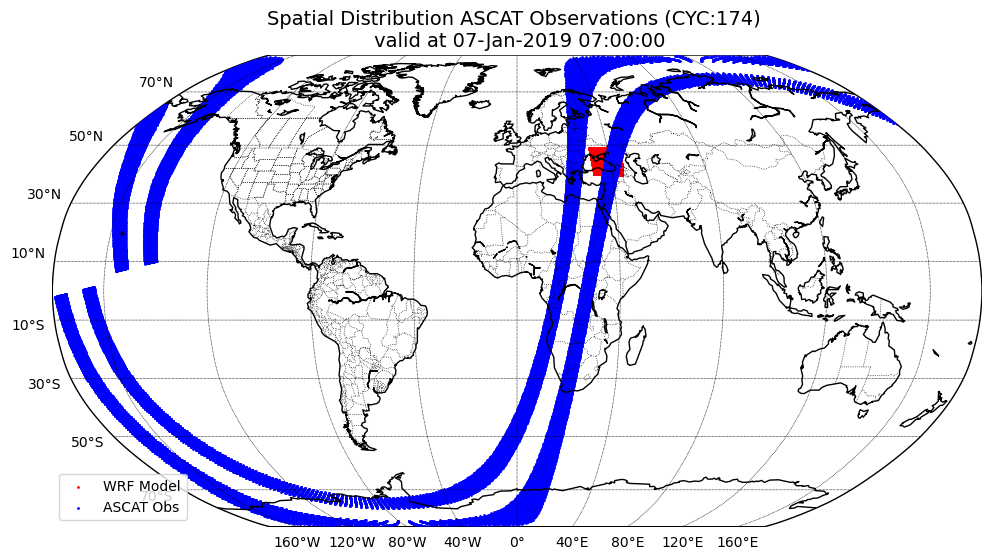

In [85]:
cyc_num = 174

# Paths and filenames Observations:
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2019/CYC_174/007'
file_name_ASCAT = 'ascat_20190107_070000_metopa_63400_eps_o_coa_3201_ovw.l2.nc'

# Paths and filenames WRF:
WRF_path        = '/scratch/bidc/DCC/medTRACK_0174/'
file_name_WRF   = 'medCYC_0174_d02_2019-01-07_07_00_00'

# Paths and filenames ERA5:
ERA5_path       = '/scratch/bidc/DCC/CYC_174/'
file_name_ERA5  = 'ERA5_AN_20190107_0700_sfc'

parts = file_name_WRF.split('_')
date_str = parts[3] + ' ' + parts[4]  + parts[5] + parts[6] # Combine date and time parts
date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')
print(date)
Plot_Check_ASCATvsWRF(mapa_d02,ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,cyc_num,date)

#### Comparing wind fields from Observations, WRF and ERA5:

2019-01-07 07:00:00
RMSE wspeed10m between model and observations: 7.93 m/s
RMSE ERA5 wspeed10m between model and observations: 1.08 m/s
RMSE u10m between model and observations: 10.23 m/s
RMSE ERA5 u10m between model and observations: 1.20 m/s
RMSE v10m between model and observations: 3.74 m/s
RMSE ERA5 v10m between model and observations: 1.23 m/s


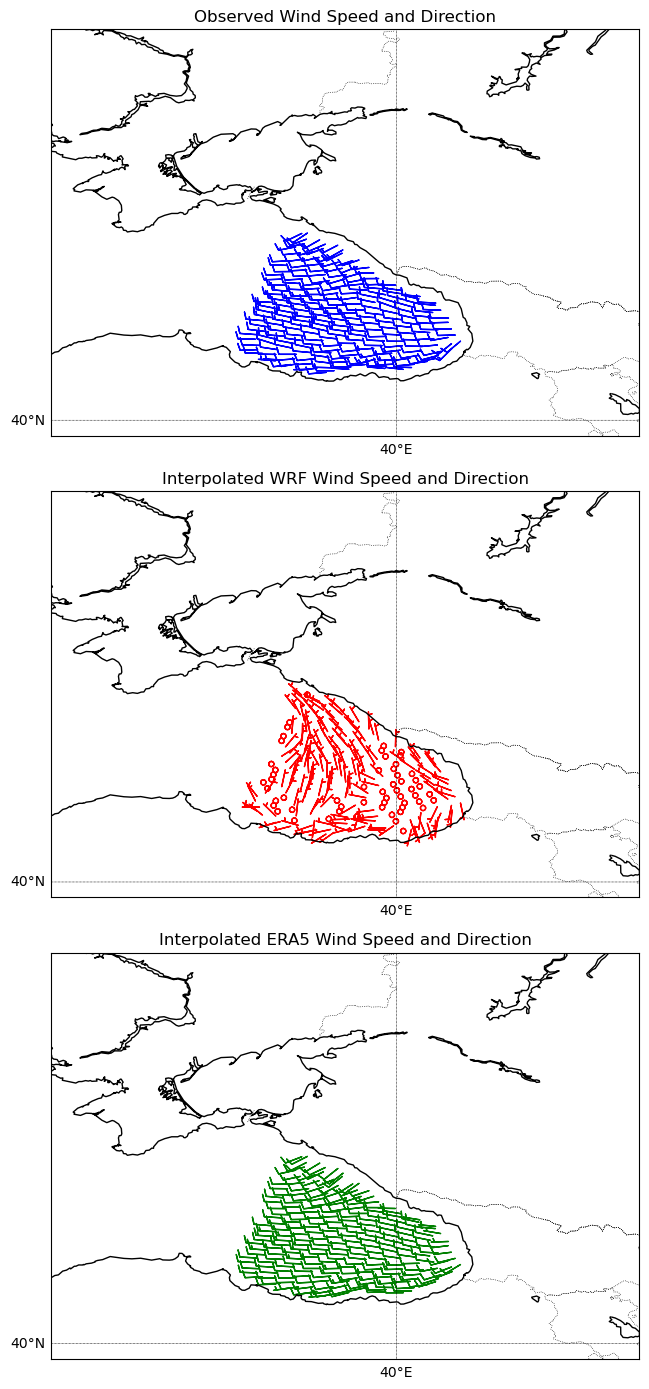

In [86]:
parts = file_name_WRF.split('_')
date_str = parts[3] + ' ' + parts[4]  + parts[5] + parts[6] # Combine date and time parts
date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')
print(date)
# Here goes CODE to validate ERA5 and WRF nested simulations using ASCAT observations:
[rmse_wspeed10m, rmse_u10m, rmse_v10m, rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m] = Computing_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,ERA5_path,file_name_ERA5)

#### Plotting ASCAT obs (RAW data):

ASCAT_path:  /scratch/bidc/DCC/EUMETSAT_Obs/2019/CYC_174/007
File_name_ASCAT: ascat_20190107_070000_metopa_63400_eps_o_coa_3201_ovw.l2.nc


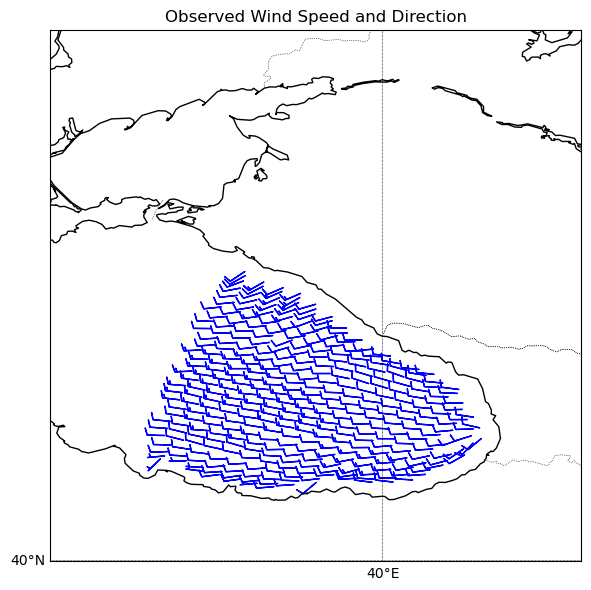

In [61]:
print('ASCAT_path: ', ASCAT_path)
print('File_name_ASCAT:', file_name_ASCAT)
#
# Loading ASCAT geographical coordinates:
#
ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
lat_obs         = ascat_obs['lat'][:,:].data
lon_obs         = ascat_obs['lon'][:,:].data
ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable

#
# Define the bounding box for the model domain:
#
wrf_lat_min, wrf_lat_max = 38, 48
wrf_lon_min, wrf_lon_max = 35, 43
#
# Define mask and apply it to the observations:
#
mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
lat_obs_filtered         = lat_obs[mask_obs]
lon_obs_filtered         = lon_obs[mask_obs]
ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    
#
# =========================================================
# Plotting:
# =========================================================
#
# Create the Basemap instance:
m = Basemap(projection='cyl', resolution='i',
        llcrnrlat=40, urcrnrlat=48,
        llcrnrlon=35, urcrnrlon=43)
#
# Plotting the data:
#
fig = plt.figure(figsize=(6, 6))
#
# First subplot: Observed wind speed and direction:
# 
ax1 = fig.add_subplot(111)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting:
#
x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
#
# Calculate u and v components for observed wind:
#
u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
#
# Plot wind barbs for observed wind speed and direction:
#
barb_density = 2  # Controls the density of barbs
#m.barbs(x_obs[::barb_density,::barb_density], y_obs[::barb_density,::barb_density], u_obs[::barb_density,::barb_density], v_obs[::barb_density,::barb_density], length=5, color='blue')
m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
plt.title('Observed Wind Speed and Direction')
plt.tight_layout()
#plt.show()
# Save the figure
fig.savefig('Wind_Speed_and_Direction_ASCAT_CYC'+str(cyc_num)+'.png', dpi=300)

#### Plotting nested WRF (RAW data):

WRF_path:  /scratch/bidc/DCC/medTRACK_0174/
File_name_WRF: medCYC_0174_d02_2019-01-07_07_00_00


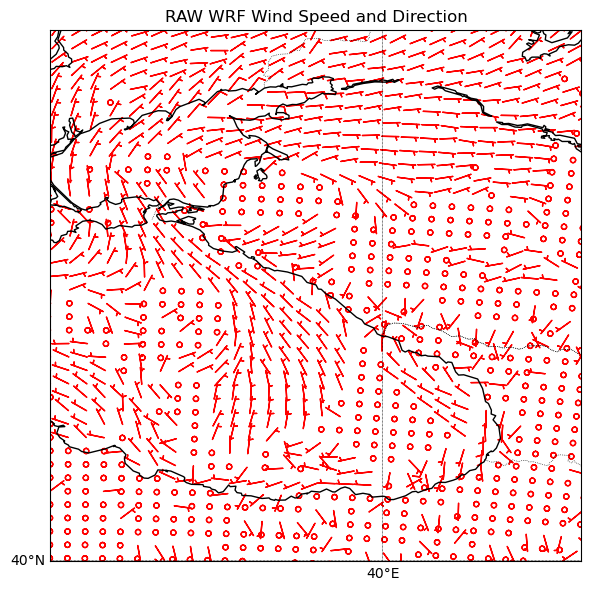

In [87]:
print('WRF_path: ', WRF_path)
print('File_name_WRF:', file_name_WRF)
#
# Loading WRF geographical coordinates:
#
data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
lat_wrf    = data_wrf['XLAT'][0,:,:].data
lon_wrf    = data_wrf['XLONG'][0,:,:].data
u10m_wrf   = data_wrf['U10'][0,:,:].data
v10m_wrf   = data_wrf['V10'][0,:,:].data
wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)

# =========================================================
# Plotting:
# =========================================================
#
# Create the Basemap instance:
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=40, urcrnrlat=48,
            llcrnrlon=35, urcrnrlon=43)
#
# Plotting the data:
#
fig = plt.figure(figsize=(6, 6))
#
# First subplot: Observed wind speed and direction:
# 
ax1 = fig.add_subplot(111)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting:
#
x_obs, y_obs = m(lon_wrf, lat_wrf)

# Plot wind barbs for interpolated WRF wind speed and direction
barb_density = 8  # Controls the density of barbs
m.barbs(x_obs[::barb_density,::barb_density], y_obs[::barb_density,::barb_density], u10m_wrf[::barb_density,::barb_density], v10m_wrf[::barb_density,::barb_density], length=5, color='red')
plt.title('RAW WRF Wind Speed and Direction')
plt.tight_layout()
#plt.show()
# Save the figure
fig.savefig('Wind_Speed_and_Direction_WRF_CYC'+str(cyc_num)+'.png', dpi=300)


#### Plotting ERA5 (RAW data):

ERA5_path:  /scratch/bidc/DCC/CYC_174/
File_name_ERA5: ERA5_AN_20190107_0700_sfc


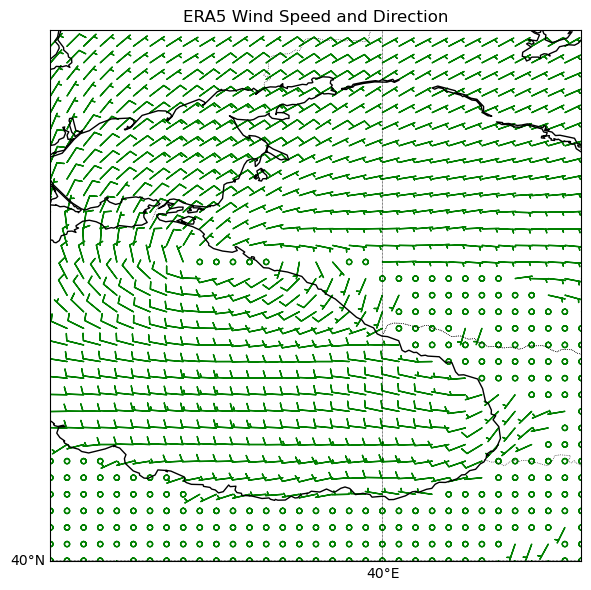

In [63]:
print('ERA5_path: ', ERA5_path)
print('File_name_ERA5:', file_name_ERA5)
#
# Loading ERA5 geographical coordinates:
#
#Opening ERA5 Grib files:
ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
# Obtaining variables of interest from ERA5 files:
lat_era5 = ds['latitude']
lon_era5 = ds['longitude']
u10m_era5 = ds['u10'].values
v10m_era5 = ds['v10'].values
# Computing wind speed:
wspeed_era5 = np.sqrt(u10m_era5**2 + v10m_era5**2)
# Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
[lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)

#
# =========================================================
# Plotting:
# =========================================================
#
# Create the Basemap instance:
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=40, urcrnrlat=48,
            llcrnrlon=35, urcrnrlon=43)
#
# Plotting the data:
#
fig = plt.figure(figsize=(6, 6))
#
# First subplot: Observed wind speed and direction:
# 
ax1 = fig.add_subplot(111)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting:
#
x_obs, y_obs = m(lons_era5, lats_era5)

# Plot wind barbs for interpolated WRF wind speed and direction
barb_density = 1  # Controls the density of barbs
m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_era5[::barb_density], v10m_era5[::barb_density], length=5, color='green')
plt.title('ERA5 Wind Speed and Direction')
plt.tight_layout()
#plt.show()
# Save the figure
fig.savefig('Wind_Speed_and_Direction_ERA5_CYC'+str(cyc_num)+'.png', dpi=300)

#### Check the BEST WRF simulation vs ERA5 using ASCAT observations:

2013-02-01 09:00:00


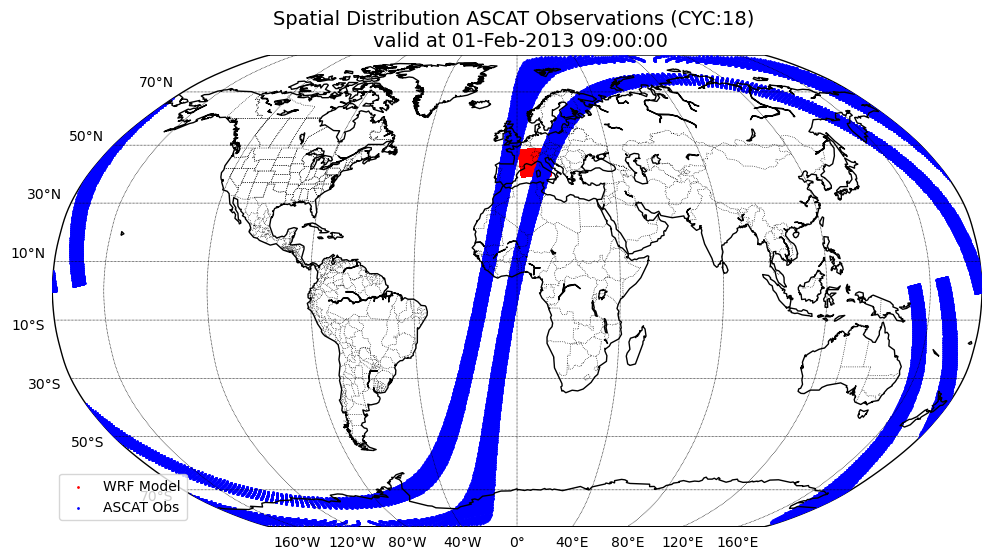

In [88]:
cyc_num = 18

# Paths and filenames Observations:
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2013/CYC_18/032'
file_name_ASCAT = 'ascat_20130201_090900_metopa_32629_eps_o_coa_2101_ovw.l2.nc'

# Paths and filenames WRF:
WRF_path        = '/scratch/bidc/DCC/medTRACK_0018/'
file_name_WRF   = 'medCYC_0018_d02_2013-02-01_09_00_00'

# Paths and filenames ERA5:
ERA5_path       = '/scratch/bidc/DCC/CYC_18/'
file_name_ERA5  = 'ERA5_AN_20130201_0900_sfc'

parts = file_name_WRF.split('_')
date_str = parts[3] + ' ' + parts[4]  + parts[5] + parts[6] # Combine date and time parts
date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')
print(date)
Plot_Check_ASCATvsWRF(mapa_d02,ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,cyc_num,date)

Ignoring index file '/scratch/bidc/DCC/CYC_18//ERA5_AN_20130201_0900_sfc.9093e.idx' older than GRIB file


2013-02-01 09:00:00


RMSE wspeed10m between model and observations: 2.44 m/s
RMSE ERA5 wspeed10m between model and observations: 1.93 m/s
RMSE u10m between model and observations: 2.93 m/s
RMSE ERA5 u10m between model and observations: 2.35 m/s
RMSE v10m between model and observations: 2.25 m/s
RMSE ERA5 v10m between model and observations: 1.81 m/s


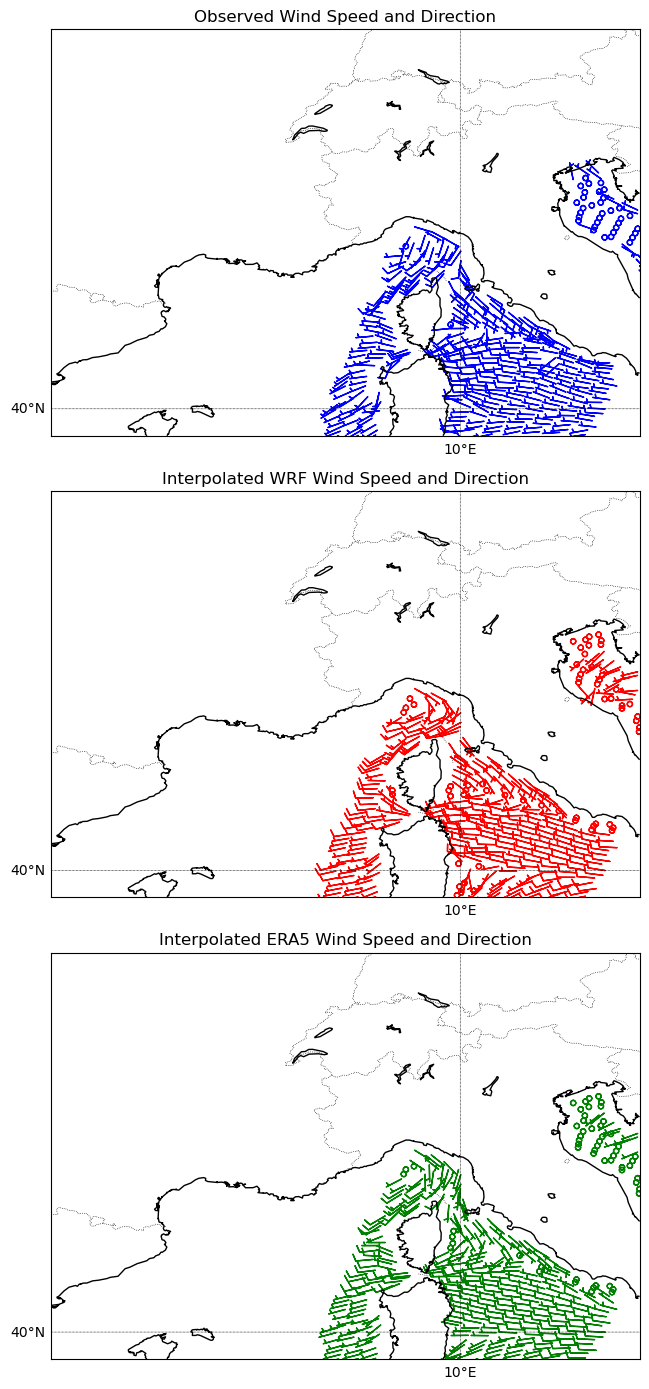

In [89]:
parts = file_name_WRF.split('_')
date_str = parts[3] + ' ' + parts[4]  + parts[5] + parts[6] # Combine date and time parts
date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')
print(date)
# Here goes CODE to validate ERA5 and WRF nested simulations using ASCAT observations:
[rmse_wspeed10m, rmse_u10m, rmse_v10m, rmse_era5_wspeed10m, rmse_era5_u10m, rmse_era5_v10m] = Computing_RMSE_and_Plotting_Winds(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,ERA5_path,file_name_ERA5)

#### Plotting ASCAT obs (RAW data):

ASCAT_path:  /scratch/bidc/DCC/EUMETSAT_Obs/2013/CYC_18/032
File_name_ASCAT: ascat_20130201_090900_metopa_32629_eps_o_coa_2101_ovw.l2.nc


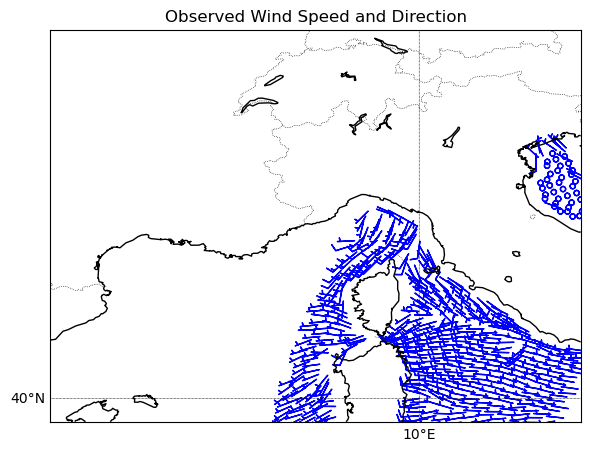

In [76]:
print('ASCAT_path: ', ASCAT_path)
print('File_name_ASCAT:', file_name_ASCAT)
#
# Loading ASCAT geographical coordinates:
#
ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
lat_obs         = ascat_obs['lat'][:,:].data
lon_obs         = ascat_obs['lon'][:,:].data
ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable

#
# Define the bounding box for the model domain:
#
wrf_lat_min, wrf_lat_max = 38, 48
wrf_lon_min, wrf_lon_max = 2, 20
#
# Define mask and apply it to the observations:
#
mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
lat_obs_filtered         = lat_obs[mask_obs]
lon_obs_filtered         = lon_obs[mask_obs]
ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    
#
# =========================================================
# Plotting:
# =========================================================
#
# Create the Basemap instance:
m = Basemap(projection='cyl', resolution='i',
        llcrnrlat=39.5, urcrnrlat=48,
        llcrnrlon=2, urcrnrlon=13.5)
#
# Plotting the data:
#
fig = plt.figure(figsize=(6, 6))
#
# First subplot: Observed wind speed and direction:
# 
ax1 = fig.add_subplot(111)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting:
#
x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
#
# Calculate u and v components for observed wind:
#
u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
#
# Plot wind barbs for observed wind speed and direction:
#
barb_density = 2  # Controls the density of barbs
#m.barbs(x_obs[::barb_density,::barb_density], y_obs[::barb_density,::barb_density], u_obs[::barb_density,::barb_density], v_obs[::barb_density,::barb_density], length=5, color='blue')
m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
plt.title('Observed Wind Speed and Direction')
plt.tight_layout()
#plt.show()
# Save the figure
fig.savefig('Wind_Speed_and_Direction_ASCAT_CYC'+str(cyc_num)+'.png', dpi=300)

#### Plotting nested WRF (RAW data):

WRF_path:  /scratch/bidc/DCC/medTRACK_0018/
File_name_WRF: medCYC_0018_d02_2013-02-01_09_00_00


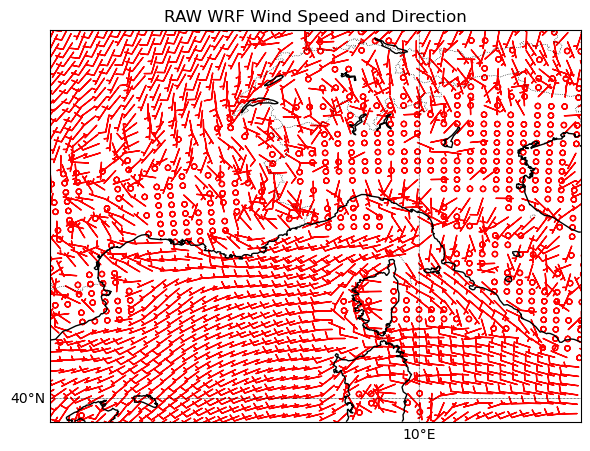

In [75]:
print('WRF_path: ', WRF_path)
print('File_name_WRF:', file_name_WRF)
#
# Loading WRF geographical coordinates:
#
data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
lat_wrf    = data_wrf['XLAT'][0,:,:].data
lon_wrf    = data_wrf['XLONG'][0,:,:].data
u10m_wrf   = data_wrf['U10'][0,:,:].data
v10m_wrf   = data_wrf['V10'][0,:,:].data
wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)

# =========================================================
# Plotting:
# =========================================================
#
# Create the Basemap instance:
m = Basemap(projection='cyl', resolution='i',
        llcrnrlat=39.5, urcrnrlat=48,
        llcrnrlon=2, urcrnrlon=13.5)
#
# Plotting the data:
#
fig = plt.figure(figsize=(6, 6))
#
# First subplot: Observed wind speed and direction:
# 
ax1 = fig.add_subplot(111)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting:
#
x_obs, y_obs = m(lon_wrf, lat_wrf)

# Plot wind barbs for interpolated WRF wind speed and direction
barb_density = 8  # Controls the density of barbs
m.barbs(x_obs[::barb_density,::barb_density], y_obs[::barb_density,::barb_density], u10m_wrf[::barb_density,::barb_density], v10m_wrf[::barb_density,::barb_density], length=5, color='red')
plt.title('RAW WRF Wind Speed and Direction')
plt.tight_layout()
#plt.show()
# Save the figure
fig.savefig('Wind_Speed_and_Direction_WRF_CYC'+str(cyc_num)+'.png', dpi=300)


#### Plotting ERA5 (RAW data):

Ignoring index file '/scratch/bidc/DCC/CYC_18//ERA5_AN_20130201_0900_sfc.9093e.idx' older than GRIB file


ERA5_path:  /scratch/bidc/DCC/CYC_18/
File_name_ERA5: ERA5_AN_20130201_0900_sfc


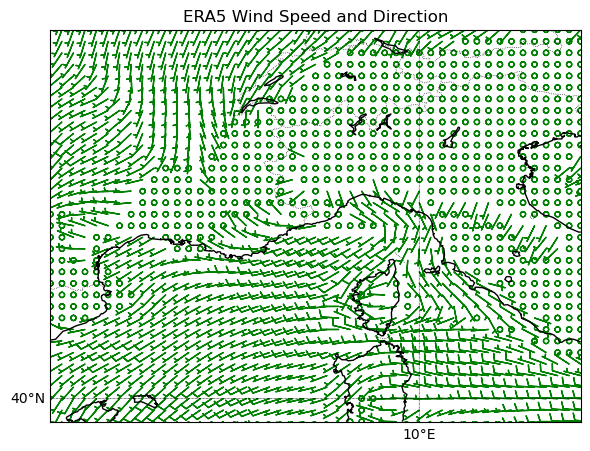

In [77]:
print('ERA5_path: ', ERA5_path)
print('File_name_ERA5:', file_name_ERA5)
#
# Loading ERA5 geographical coordinates:
#
#Opening ERA5 Grib files:
ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
# Obtaining variables of interest from ERA5 files:
lat_era5 = ds['latitude']
lon_era5 = ds['longitude']
u10m_era5 = ds['u10'].values
v10m_era5 = ds['v10'].values
# Computing wind speed:
wspeed_era5 = np.sqrt(u10m_era5**2 + v10m_era5**2)
# Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
[lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)

#
# =========================================================
# Plotting:
# =========================================================
#
# Create the Basemap instance:
m = Basemap(projection='cyl', resolution='i',
        llcrnrlat=39.5, urcrnrlat=48,
        llcrnrlon=2, urcrnrlon=13.5)
#
# Plotting the data:
#
fig = plt.figure(figsize=(6, 6))
#
# First subplot: Observed wind speed and direction:
# 
ax1 = fig.add_subplot(111)
m.drawcoastlines(color="black", linewidth=1)
m.drawstates(linestyle="dotted")
m.drawcountries(linestyle="dotted")
parallels = np.arange(-90, 90, 10)
meridians = np.arange(0, 360, 10)
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
#
# Transform coordinates for plotting:
#
x_obs, y_obs = m(lons_era5, lats_era5)

# Plot wind barbs for interpolated WRF wind speed and direction
barb_density = 1  # Controls the density of barbs
m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_era5[::barb_density], v10m_era5[::barb_density], length=5, color='green')
plt.title('ERA5 Wind Speed and Direction')
plt.tight_layout()
#plt.show()
# Save the figure
fig.savefig('Wind_Speed_and_Direction_ERA5_CYC'+str(cyc_num)+'.png', dpi=300)

# -------------------------------------------------------------------------

In [98]:
def Computing_RMSE_and_Plotting_Winds_D01(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,file_name_parent_WRF,ERA5_path,file_name_ERA5):
    #
    # Loading ASCAT geographical coordinates:
    #
    ascat_obs       = Dataset(ASCAT_path + '/' + file_name_ASCAT)
    lat_obs         = ascat_obs['lat'][:,:].data
    lon_obs         = ascat_obs['lon'][:,:].data
    ascat_wspeed10m = ascat_obs['wind_speed'][:,:].data  # Replace 'variable_name' with the actual variable
    ascat_wdir10m   = ascat_obs['wind_dir'][:,:].data  # Replace 'variable_name' with the actual variable
    #
    # Loading ERA5 geographical coordinates:
    #
    #Opening ERA5 Grib files:
    ds = xr.open_dataset(ERA5_path + '/' + file_name_ERA5, engine='cfgrib',backend_kwargs={'errors': 'ignore'})
    # Obtaining variables of interest from ERA5 files:
    lat_era5 = ds['latitude']
    lon_era5 = ds['longitude']
    u10m_era5 = ds['u10'].values
    v10m_era5 = ds['v10'].values
    # Computing wind speed:
    wspeed_era5 = np.sqrt(u10m_era5**2 + v10m_era5**2)
    # Transform 1-dim lon_era5 and lat_era5 arrays to 2-dim arrays:
    [lons_era5,lats_era5] = np.meshgrid(lon_era5,lat_era5)
    #
    # Loading parent WRF geographical coordinates:
    #
    data_d01_wrf   = Dataset(WRF_path + '/' + file_name_parent_WRF)
    lat_d01_wrf    = data_d01_wrf['XLAT'][0,:,:].data
    lon_d01_wrf    = data_d01_wrf['XLONG'][0,:,:].data
    u10m_d01_wrf   = data_d01_wrf['U10'][0,:,:].data
    v10m_d01_wrf   = data_d01_wrf['V10'][0,:,:].data
    wspeed_d01_wrf = np.sqrt(u10m_d01_wrf**2 + v10m_d01_wrf**2)        
    #
    # Loading WRF geographical coordinates:
    #
    data_wrf   = Dataset(WRF_path + '/' + file_name_WRF)
    lat_wrf    = data_wrf['XLAT'][0,:,:].data
    lon_wrf    = data_wrf['XLONG'][0,:,:].data
    u10m_wrf   = data_wrf['U10'][0,:,:].data
    v10m_wrf   = data_wrf['V10'][0,:,:].data
    wspeed_wrf = np.sqrt(u10m_wrf**2 + v10m_wrf**2)
    #
    # Define the bounding box for the model domain:
    #
    wrf_lat_min, wrf_lat_max = np.min(lat_wrf), np.max(lat_wrf)
    wrf_lon_min, wrf_lon_max = np.min(lon_wrf), np.max(lon_wrf)
    #
    # Define mask and apply it to the observations:
    #
    mask_obs = (lat_obs >= wrf_lat_min) & (lat_obs <= wrf_lat_max) & (lon_obs >= wrf_lon_min) & (lon_obs <= wrf_lon_max) & (ascat_wspeed10m >= -500)
    lat_obs_filtered         = lat_obs[mask_obs]
    lon_obs_filtered         = lon_obs[mask_obs]
    ascat_wspeed10m_filtered = ascat_wspeed10m[mask_obs]
    ascat_wdir10m_filtered   = ascat_wdir10m[mask_obs]
    #
    # Flatten the filtered observation and model grids for interpolation:
    #
    points_d01_wrf  = np.c_[lon_d01_wrf.flatten(), lat_d01_wrf.flatten()]
    points_wrf      = np.c_[lon_wrf.flatten(), lat_wrf.flatten()]
    points_era5     = np.c_[lons_era5.flatten(), lats_era5.flatten()]
    values_era5     = wspeed_era5.flatten()
    values_d01_wrf  = wspeed_d01_wrf.flatten()
    values_wrf      = wspeed_wrf.flatten()
    points_mesh     = np.c_[lon_obs_filtered.flatten(), lat_obs_filtered.flatten()]
    #
    # Interpolate parent wrf onto the observation grid:
    #
    wrf_d01_interp = griddata(points_d01_wrf, values_d01_wrf, points_mesh, method='linear', fill_value=np.nan)
    #
    # Interpolate wrf onto the observation grid:
    #
    wrf_interp    = griddata(points_wrf, values_wrf, points_mesh, method='linear', fill_value=np.nan)
    #
    #
    # Interpolate ERA5 onto the observation grid:
    #
    era5_interp  = griddata(points_era5, values_era5, points_mesh, method='linear', fill_value=np.nan)
    #
    # Interpolate u and v components of parent WRF wind to observation sites:
    #
    u10m_wrf_d01_interp = griddata(points_d01_wrf, u10m_d01_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_wrf_d01_interp = griddata(points_d01_wrf, v10m_d01_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of WRF wind to observation sites:
    #
    u10m_wrf_interp = griddata(points_wrf, u10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_wrf_interp = griddata(points_wrf, v10m_wrf.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # Interpolate u and v components of ERA5 wind to observation sites:
    #
    u10m_era5_interp = griddata(points_era5, u10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    v10m_era5_interp = griddata(points_era5, v10m_era5.flatten(), points_mesh, method='nearest', fill_value=np.nan)
    #
    # =========================================================
    # Compute RMSE:
    # =========================================================
    # Remove NaN values for RMSE computation
    valid_mask = ~np.isnan(wrf_interp) & ~np.isnan(ascat_wspeed10m_filtered)
    wrf_d01_interp_valid  = wrf_d01_interp[valid_mask]
    wrf_interp_valid      = wrf_interp[valid_mask]
    era5_interp_valid     = era5_interp[valid_mask]
    ascat_wspeed10m_valid = ascat_wspeed10m_filtered[valid_mask]
    ascat_u10m            = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    ascat_v10m            = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    rmse_wrfd01_wspeed10m  = np.sqrt(np.mean((wrf_d01_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_wrfd02_wspeed10m  = np.sqrt(np.mean((wrf_interp_valid - ascat_wspeed10m_valid) ** 2))
    rmse_era5_wspeed10m    = np.sqrt(np.mean((era5_interp_valid - ascat_wspeed10m_valid) ** 2))
    #
    print(f'RMSE WRF_d01 wspeed10m between model and observations: {rmse_wrfd01_wspeed10m:.2f} m/s')
    print(f'RMSE WRF_d02 wspeed10m between model and observations: {rmse_wrfd02_wspeed10m:.2f} m/s')
    print(f'RMSE ERA5 wspeed10m between model and observations: {rmse_era5_wspeed10m:.2f} m/s')
    #
    # =========================================================
    # Plotting:
    # =========================================================
    #
    # Create the Basemap instance:
    m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=wrf_lat_min, urcrnrlat=wrf_lat_max,
                llcrnrlon=wrf_lon_min, urcrnrlon=wrf_lon_max)
    #
    # Plotting the data:
    #
    fig = plt.figure(figsize=(14, 14))
    #
    # First subplot: Observed wind speed and direction:
    # 
    ax1 = fig.add_subplot(311)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    parallels = np.arange(-90, 90, 10)
    meridians = np.arange(0, 360, 10)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    #
    # Transform coordinates for plotting:
    #
    x_obs, y_obs = m(lon_obs_filtered, lat_obs_filtered)
    #
    # Calculate u and v components for observed wind:
    #
    u_obs = ascat_wspeed10m_filtered * np.cos(np.radians(90 - ascat_wdir10m_filtered))
    v_obs = ascat_wspeed10m_filtered * np.sin(np.radians(90 - ascat_wdir10m_filtered))
    #
    # Plot wind barbs for observed wind speed and direction:
    #
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u_obs[::barb_density], v_obs[::barb_density], length=5, color='blue')
    plt.title('Observed Wind Speed and Direction')
    #
    # Second subplot: Interpolated WRF wind speed and direction:
    #
    ax2 = fig.add_subplot(312)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_wrf_d01_interp[::barb_density], v10m_wrf_d01_interp[::barb_density], length=5, color='red')
    plt.title('Interpolated WRF (D01) Wind Speed and Direction')
    plt.tight_layout()
    #plt.show()
    #
    # Third subplot: Interpolated ERA5 wind speed and direction:
    #
    ax2 = fig.add_subplot(313)
    m.drawcoastlines(color="black", linewidth=1)
    m.drawstates(linestyle="dotted")
    m.drawcountries(linestyle="dotted")
    m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5)
    # Plot wind barbs for interpolated WRF wind speed and direction
    barb_density = 3  # Controls the density of barbs
    m.barbs(x_obs[::barb_density], y_obs[::barb_density], u10m_era5_interp[::barb_density], v10m_era5_interp[::barb_density], length=5, color='green')
    plt.title('Interpolated ERA5 Wind Speed and Direction')
    plt.tight_layout()
    #plt.show()
    # Save the figure
    fig.savefig('Interpolated_WRFandERA5_Wind_Speed_and_Direction_'+ file_name_WRF +'_D01.png', dpi=300)
    return rmse_wrfd01_wspeed10m, rmse_wrfd02_wspeed10m, rmse_era5_wspeed10m

2019-01-07 07:00:00


2019-01-07 07:00:00
RMSE WRF_d01 wspeed10m between model and observations: 7.96 m/s
RMSE WRF_d02 wspeed10m between model and observations: 7.93 m/s
RMSE ERA5 wspeed10m between model and observations: 1.08 m/s


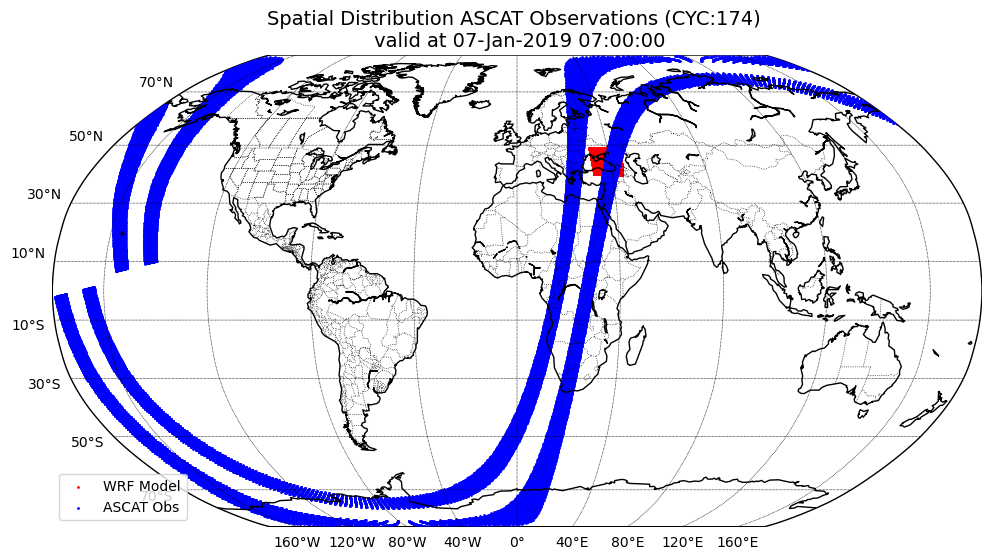

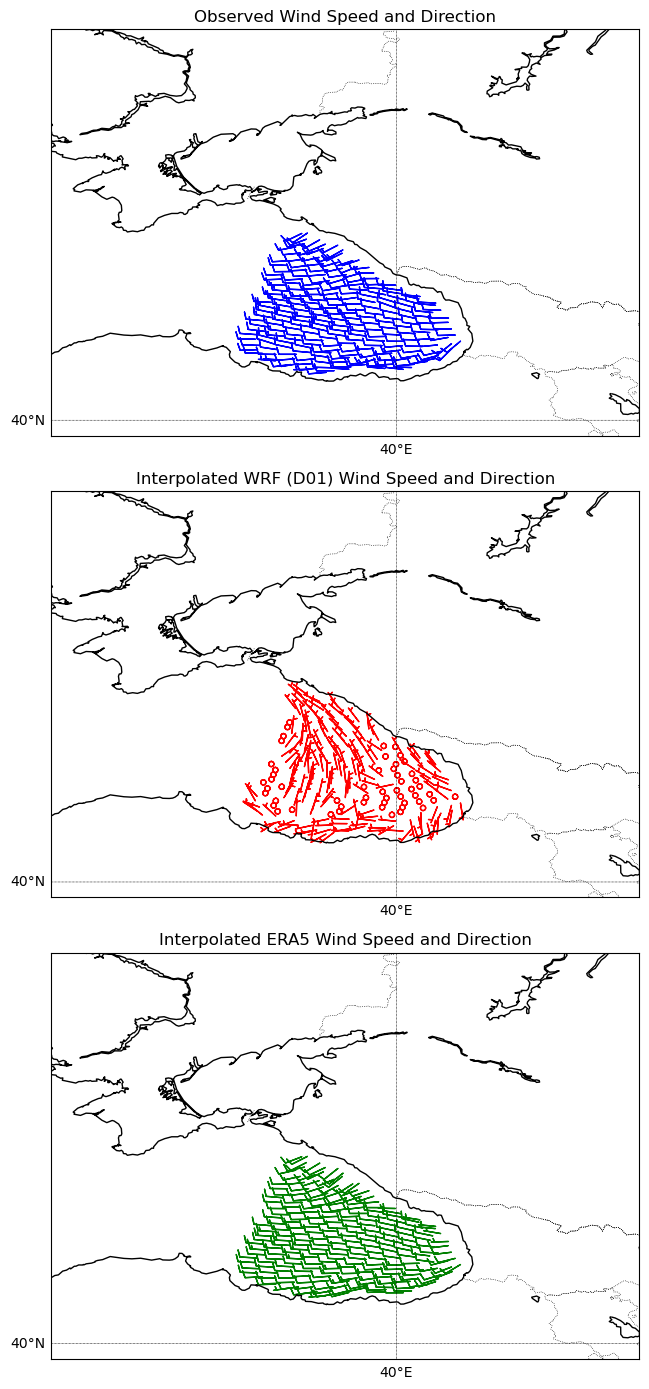

In [99]:
cyc_num = 174

# Paths and filenames Observations:
ASCAT_path      = '/scratch/bidc/DCC/EUMETSAT_Obs/2019/CYC_174/007'
file_name_ASCAT = 'ascat_20190107_070000_metopa_63400_eps_o_coa_3201_ovw.l2.nc'

# Paths and filenames WRF:
WRF_path               = '/scratch/bidc/DCC/medTRACK_0174/'
file_name_WRF          = 'medCYC_0174_d02_2019-01-07_07_00_00'
file_name_parent_WRF   = 'medCYC_0174_d01_2019-01-07_07_00_00'


# Paths and filenames ERA5:
ERA5_path       = '/scratch/bidc/DCC/CYC_174/'
file_name_ERA5  = 'ERA5_AN_20190107_0700_sfc'

parts = file_name_WRF.split('_')
date_str = parts[3] + ' ' + parts[4]  + parts[5] + parts[6] # Combine date and time parts
date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')
print(date)
Plot_Check_ASCATvsWRF(mapa_d02,ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,cyc_num,date)

parts = file_name_WRF.split('_')
date_str = parts[3] + ' ' + parts[4]  + parts[5] + parts[6] # Combine date and time parts
date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')
print(date)
# Here goes CODE to validate ERA5 and WRF nested simulations using ASCAT observations:
[rmse_wrf_d01_wspeed10m,rmse_wrf_d02_wspeed10m, rmse_era5_wspeed10m] = Computing_RMSE_and_Plotting_Winds_D01(ASCAT_path,file_name_ASCAT,WRF_path,file_name_WRF,file_name_parent_WRF,ERA5_path,file_name_ERA5)